 # GAN para generación de caras

 Usamos el dataset CelebA para entrenar una red neuronal generativa antagónica para generar caras.


In [6]:
#Importa las librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

## Inmportación de datos

In [7]:

(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()


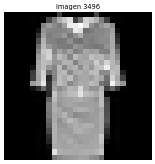

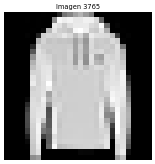

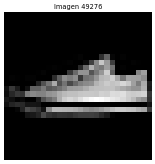

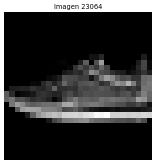

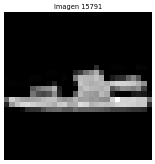

In [8]:
# Carga y muestar algunas imágenes del dataset
sample_indices = random.sample(range(len(train_images)), 5) # Selecciona imagens aleatorioas

for image in sample_indices:
  img = train_images[image]
  plt.figure(dpi=40)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f"Imagen {image}")
  plt.show()

In [9]:
# Parámetros del dataset y del modelo
IMG_SIZE = (28, 28)
BATCH_SIZE = 64
NUMBER_OF_IMAGES = 60000 # Todas las imagenes de entrenamiento

# Procesa las imaágenes del dataset
images = []
for image in train_images[:NUMBER_OF_IMAGES]:
  img = img_to_array(image)  / 127.5 - 1.0 # Normaliza entre -1 y 1
  images.append(img)

  # Convierte las imágenes a un array de numpy y prepeara el datset de TensorFlow
  dataset = np.array(images)
  dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)

print(f"Dataset procesado: {NUMBER_OF_IMAGES} imágenes cargadas y preparadas.")

Dataset procesado: 60000 imágenes cargadas y preparadas.


In [10]:
# Verifica la estructura del dataset
for batch in dataset.take(1):
  print("Dimensiones del lote:", batch.shape)
  print("Rango: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (64, 28, 28, 1)
Rango: de -1.0 a 1.0


In [11]:
# Define el generador
LATENT_DIM = 400

generator = keras.Sequential([
        # Capa de entrada para el ruido y la etiqueta de clase
    layers.InputLayer(input_shape=(LATENT_DIM,)),

    # Capa densa inicial
    layers.Dense(6 * 7 * 512, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensión a las dimensiones iniciales
    layers.Reshape((6, 7, 512)),

    # Primera capa de convolución
    layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Cuarta capa de convolución
    layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),


    # Capa final de ajuste a 28x28x1 (imagen en escala de grises)
    layers.Conv2D(1, (69, 85), activation="tanh")  # Cambio a 1 canal de salida y ajuste de tamaño de filtro


])

generator.summary()

c:\Users\janto\Documents\alan turing\mnist gan\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21504)          │     8,601,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21504)          │        86,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 14, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 12, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 28, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 56, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 112, 32)    │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 112, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 96, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 1)      │       187,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,229,217 (50.47 MB)

 Trainable params: 13,185,249 (50.30 MB)

 Non-trainable params: 43,968 (171.75 KB)

In [12]:
# Dimensiones de cada capa
noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(f"{layer.name}: {x.shape}")

dense: (1, 21504)
batch_normalization: (1, 21504)
leaky_re_lu: (1, 21504)
reshape: (1, 6, 7, 512)
conv2d_transpose: (1, 12, 14, 256)
batch_normalization_1: (1, 12, 14, 256)
leaky_re_lu_1: (1, 12, 14, 256)
conv2d_transpose_1: (1, 24, 28, 128)
batch_normalization_2: (1, 24, 28, 128)
leaky_re_lu_2: (1, 24, 28, 128)
conv2d_transpose_2: (1, 48, 56, 64)
batch_normalization_3: (1, 48, 56, 64)
leaky_re_lu_3: (1, 48, 56, 64)
conv2d_transpose_3: (1, 96, 112, 32)
batch_normalization_4: (1, 96, 112, 32)
leaky_re_lu_4: (1, 96, 112, 32)
conv2d: (1, 28, 28, 1)


In [13]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 28, 28, 1)


Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: de -0.017763108 a 0.012661957


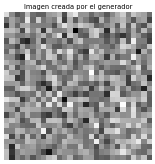

In [14]:
# Comprueba que el generador está funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada

print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())
# muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="grey") # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis('off')
plt.title("Imagen creada por el generador")
plt.show()

In [15]:
# Define el discriminador
discriminator = keras.Sequential([
    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid") # Decide si la imagen es real o generada

])

c:\Users\janto\Documents\alan turing\mnist gan\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Muestra el resumen del modelo
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Prueba el discriminador con la imagen cread por el generador

noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.50014246]]


Es normal que el discriminador indique incertidumbre por que todavía no hemos entrenado la GAN.

In [18]:
# Inpecciona un lote del dataset
for batch in dataset.take(1):
  print("Dimensiones del lote:", batch.shape)
  break

Dimensiones del lote: (64, 28, 28, 1)


In [19]:
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False) # No se necita logits poque la última capa era una sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

**Gradientes**: Son vectores que indican dirección y magnitud en la que aujstarse los pesos de un modelo para minimizar una función de pérdida.

Época 1/100
Pérdida del discriminador: 1.3623735904693604, Pérdida del generador: 0.6654727458953857
Pérdida del discriminador: 1.4534060955047607, Pérdida del generador: 0.5653284788131714
Pérdida del discriminador: 1.4267125129699707, Pérdida del generador: 0.6003477573394775
Pérdida del discriminador: 1.3801133632659912, Pérdida del generador: 0.6407256126403809
Pérdida del discriminador: 1.3318425416946411, Pérdida del generador: 0.6867152452468872
Pérdida del discriminador: 1.2889732122421265, Pérdida del generador: 0.7363444566726685
Pérdida del discriminador: 1.2714807987213135, Pérdida del generador: 0.7905752658843994
Pérdida del discriminador: 1.2153209447860718, Pérdida del generador: 0.8464576005935669
Pérdida del discriminador: 1.1417611837387085, Pérdida del generador: 0.9044552445411682
Pérdida del discriminador: 1.1455711126327515, Pérdida del generador: 0.9642127156257629
Pérdida del discriminador: 1.1116153001785278, Pérdida del generador: 1.0274237394332886
Pérdida d

[main 9dfae7f] Actualización de modelos
 3 files changed, 195 insertions(+), 208 deletions(-)
 create mode 100644 model/discriminador_1ep_60000img.keras
 create mode 100644 model/generador_mnist_1ep_60000img.keras


remote: warning: See https://gh.io/lfs for more information.        
remote: warning: File model/generador_mnist_1ep_60000img.keras is 50.53 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To https://github.com/Antonioantona/gan_fashion_mnist
   dccc4e6..9dfae7f  main -> main


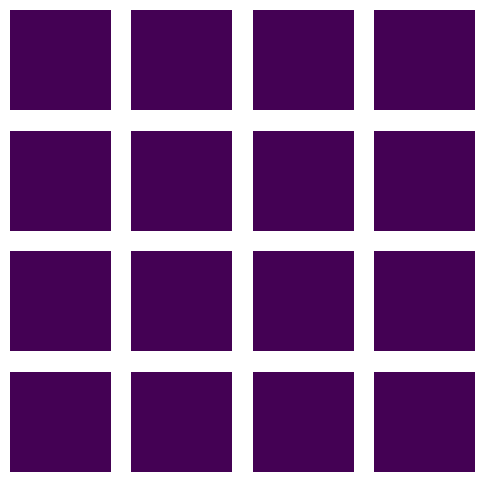

Época 2/100
Pérdida del discriminador: 0.006078680977225304, Pérdida del generador: 6.781689643859863
Pérdida del discriminador: 0.006564629264175892, Pérdida del generador: 6.886157035827637
Pérdida del discriminador: 0.02576683834195137, Pérdida del generador: 6.8639235496521
Pérdida del discriminador: 0.003999275621026754, Pérdida del generador: 6.9649577140808105
Pérdida del discriminador: 0.013301528990268707, Pérdida del generador: 7.122809886932373
Pérdida del discriminador: 0.0029946258291602135, Pérdida del generador: 7.345799922943115
Pérdida del discriminador: 0.015105095691978931, Pérdida del generador: 7.424607276916504
Pérdida del discriminador: 0.0021216082386672497, Pérdida del generador: 7.552825450897217
Pérdida del discriminador: 0.008622495457530022, Pérdida del generador: 7.604351043701172
Pérdida del discriminador: 0.003327317303046584, Pérdida del generador: 7.729560852050781
Pérdida del discriminador: 0.0017256438732147217, Pérdida del generador: 7.8712148666381

In [ ]:
EPOCHS = 100

# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    for real_images in dataset:
        # Obtiene el tamaño del lote actual
        current_batch_size = real_images.shape[0]

        # Genera ruido aleatorio para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Crea imágenes falsas con el generador
        generated_images = generator(noise, training=True)

        # Etiquetas realies y falsas
        real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
        fake_labels = tf.zeros((current_batch_size, 1)) # Imágenes generadas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
            # Obtiene las predicciones del discriminador para las imágenes reales.
            real_output = discriminator(real_images, training=True)
            # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
            fake_output = discriminator(generated_images, training=True)
            # Calcula la pérdida del discriminador para las imágenes reales.
            disc_loss_real = cross_entropy(real_labels, real_output)
            # Calcula la pérdida del discriminador para las imágenes generadas (fake).
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
            disc_loss = disc_loss_real + disc_loss_fake

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del discriminador.
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Genera ruido nuevamente para entrenar el generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrena el generador
        with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
            # Crea imágenes falsas con el generador
            generated_images = generator(noise, training=True)
            # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
            fake_output = discriminator(generated_images, training=False)
            # Calcula la pérdida del generador intentando "engañar" al discriminador.
            gen_loss = cross_entropy(real_labels, fake_output)

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del generador.
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Muestra la pérdida de cada red neuronal
        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Guarda la GAN en ficheros
    generator.save(f"model\generador_mnist_{epoch + 1}ep_60000img.keras")
    discriminator.save(f"model\discriminador_{epoch + 1}ep_60000img.keras")
    !git add .
    !git commit -m "Actualización de modelos"
    !git push
    # Muestra el progreso cada 2 épocas
    #if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
    if True:
        # Genera y muestra imágenes de ejemplo
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        plt.show()

In [ ]:
# Graba en disco los modelos.
generator = keras.models.load_model("generador_ropa_100ep_60000img.kerass")
discriminator = keras.models.load_model("discriminador_100ep_60000img.keras")

In [ ]:
# Carga los modelos en memoria. Mover bloque donde proceda (por ej. justo antes del entrenamiento)
generator = keras.models.load_model("generador_ropa_100ep_60000img.kerass")
discriminator = keras.models.load_model("discriminador_100ep_60000img.keras")

In [ ]:
# Prueba el generador cargado
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Muestra la imagen generada por el generador

print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())